In [1]:
import hail as hl
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import requests
import datetime as dt
url = 'https://raw.githubusercontent.com/nikbaya/ldscsim/master/ldscsim.py'
r = requests.get(url).text
exec(r)

In [2]:
wd = 'gs://nbaya/smiles/'

In [3]:
phen_dict = {'50_irnt':['Standing height',360388],
            '21001_irnt':['BMI',359983]}

## Make plots

### New version
No need to rerun this, skip ahead to next section

In [215]:
mt = hl.read_matrix_table(wd+phen+f'.simulation.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.mt')

In [216]:
locus_ls = hl.str(mt.locus).collect()

In [217]:
locus_df = pd.DataFrame(data = locus_ls, columns=['locus'])
locus_df.loc[locus_df.index,'ch'] = locus_df.locus.str.split(':',expand=True)[0].astype(int)
locus_df.loc[locus_df.index,'pos'] = locus_df.locus.str.split(':',expand=True)[1].astype(int)

In [218]:
ld_bm = hl.linalg.BlockMatrix.read(wd+phen+f'.r.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.bm')

In [250]:
# locus_ld_dict = dict()
# locus_ld_dict[1] = (1,2)

In [ ]:
# locus_ld_dict = dict()

In [254]:
# # Get LD matrix
# for loci_rank_tmp in range(n_top_loci):
#     start = dt.datetime.now()
#     if not loci_rank_tmp in locus_ld_dict:
#         ch, pos = top_variants[loci_rank_tmp]

#         mt1 = mt.filter_rows((hl.int(mt.locus.contig)==int(ch))&
#                             (hl.int(mt.locus.position)>=int(pos-ld_window/2))&
#                             (hl.int(mt.locus.position)<=int(pos+ld_window/2)))
#         ct = mt1.count()
#         print(ct)
#         locus_ld = hl.row_correlation(mt1.dosage)
#         locus_ld_dict[loci_rank_tmp] = (f'{ch}:{pos}',ct,locus_ld)
#     print(f'Time for locus {loci_rank_tmp}: {round((dt.datetime.now()-start).seconds/60, 2)} min')

2019-07-25 19:12:54 Hail: INFO: reading 36 of 5000 data partitions


(1155, 360338)


2019-07-25 19:13:29 Hail: INFO: reading 36 of 5000 data partitions
2019-07-25 19:21:10 Hail: INFO: Wrote all 88 blocks of 1155 x 360338 matrix with block size 4096.


Time for locus 0: 8.28 min


2019-07-25 19:21:12 Hail: INFO: reading 12 of 5000 data partitions


(1194, 360338)


2019-07-25 19:21:41 Hail: INFO: reading 12 of 5000 data partitions
2019-07-25 19:29:32 Hail: INFO: Wrote all 88 blocks of 1194 x 360338 matrix with block size 4096.


Time for locus 1: 8.35 min


2019-07-25 19:29:33 Hail: INFO: reading 11 of 5000 data partitions


(965, 360338)


2019-07-25 19:30:06 Hail: INFO: reading 11 of 5000 data partitions


KeyboardInterrupt: 

In [219]:
gwas = hl.read_table(wd+phen+f'.gwas.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.ht')
gwas = gwas.rename({'beta':'sim_betahat','standard_error':'sim_se','p_value':'sim_pval'})
gwas = gwas.drop('t_stat','y_transpose_x','sum_x')

In [220]:
gwas = gwas.annotate(sim_raf = gwas.alt_AF*(gwas.sim_betahat>0)+(1-gwas.alt_AF)*(gwas.sim_betahat<0), #risk allele frequency
                     sim_rbeta = hl.abs(gwas.sim_betahat)) #beta of risk allele

In [228]:
gwas_df0 = gwas.to_pandas()
gwas_df0['ch'] = gwas_df0['locus.contig'].astype(int)
gwas_df0['pos'] = gwas_df0['locus.position'].astype(int)
gwas_df0['real_betahat'] = gwas_df0.real_rbeta*((-1)**(gwas_df0.real_raf==1-gwas_df0.alt_AF))
gwas_df0['sim_betahat'] = gwas_df0.sim_rbeta*((-1)**(gwas_df0.sim_raf==1-gwas_df0.alt_AF))

In [229]:
#get top variants (in ascending pval order: first is most significant)
top_variants = gwas_df0[gwas_df0.sim_beta==1].sort_values(by='real_pval',ascending=True)[['ch','pos']].values

In [230]:
ss_ls = [None]*n_top_loci #list of dataframes with top loci
gwas_df_tmp = gwas_df0.copy() #dataframe from which top loci will be removed
gwas_df_keep = gwas_df_tmp[[False]*len(gwas_df_tmp)]
i = 0 
print(f'filtering to top {n_top_loci} loci of simulated data using LD window of {ld_window/1e3} kb')
while len(gwas_df_tmp)>0 and i<n_top_loci:
    ch, pos = top_variants[i]
    gwas_df_w_top_locus = gwas_df_tmp[(gwas_df_tmp.ch==ch)&(gwas_df_tmp.pos>=pos-ld_window/2)&(gwas_df_tmp.pos<=pos+ld_window/2)].copy() #extract rows around most significant hit
    gwas_df_w_top_locus['loci_rank'] = i
    gwas_df_keep = gwas_df_keep.append(gwas_df_w_top_locus)
    gwas_df_tmp = gwas_df_tmp[~((gwas_df_tmp.ch==ch)&(gwas_df_tmp.pos>=pos-ld_window/2)&(gwas_df_tmp.pos<=pos+ld_window/2))].copy() #keep rows not around most significant hit
    i += 1
gwas_df = gwas_df_keep

filtering to top 10 loci of simulated data using LD window of 300.0 kb


/opt/conda/default/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [246]:
# annotate with LD columns
for loci_rank_tmp in range(n_top_loci):
    try:
        ch, pos = top_variants[loci_rank_tmp].astype(int)
        locus_idx = locus_df[(locus_df.ch==ch)&(locus_df.pos>=pos-ld_window/2)&(locus_df.pos<=pos+ld_window/2)].index.tolist()
        variant_idx = locus_df[(locus_df.ch==ch)&(locus_df.pos==pos)].index.tolist()
        ld_np = ld_bm.filter(variant_idx,locus_idx).to_numpy()
        ld_np = ld_np.squeeze()
        gwas_df = gwas_df.sort_values(by='pos')
        gwas_df.loc[(locus_df.ch==ch)&(locus_df.pos>=pos-ld_window/2)&(locus_df.pos<=pos+ld_window/2),f'r_{loci_rank_tmp}'] = ld_np
    except ValueError:
        print(f'error for locus {loci_rank_tmp}')

KeyboardInterrupt: 

### Skip to here to make plots

In [51]:
phen = '21001_irnt'
n_top_loci = 10
ld_window=300e3

In [52]:
gwas = hl.import_table(wd+phen+f'.gwas.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.tsv.bgz',impute=True,force_bgz=True)
gwas_df = gwas.to_pandas()
top_variants = gwas_df[gwas_df.sim_beta==1].sort_values(by='real_pval',ascending=True)[['ch','pos']].values

2019-08-08 12:38:40 Hail: INFO: Reading table to impute column types
2019-08-08 12:38:41 Hail: INFO: Finished type imputation
  Loading column 'alleles' as type 'str' (imputed)
  Loading column 'alt_AF' as type 'float64' (imputed)
  Loading column 'ch' as type 'int32' (imputed)
  Loading column 'coding' as type 'bool' (imputed)
  Loading column 'loci_rank' as type 'float64' (imputed)
  Loading column 'locus.contig' as type 'int32' (imputed)
  Loading column 'locus.position' as type 'int32' (imputed)
  Loading column 'minor_AF' as type 'float64' (imputed)
  Loading column 'minor_allele' as type 'str' (imputed)
  Loading column 'n' as type 'int32' (imputed)
  Loading column 'pos' as type 'int32' (imputed)
  Loading column 'real_pval' as type 'float64' (imputed)
  Loading column 'real_raf' as type 'float64' (imputed)
  Loading column 'real_rbeta' as type 'float64' (imputed)
  Loading column 'real_varexp' as type 'float64' (imputed)
  Loading column 'sim_beta' as type 'bool' (imputed)
  Lo

In [9]:
#show top ten loci
gwas_df[gwas_df.sim_beta==1].sort_values(by='real_pval',ascending=True)[['ch','pos','real_pval','real_betahat']]

,ch,pos,real_pval,real_betahat
3511,20,34025756,0.000000e+00,0.065309
9216,3,141121814,1.250200e-285,0.059852
10305,4,145566477,4.759100e-186,0.064033
5132,2,56106928,5.671500e-162,-0.053561
499,4,17902623,7.354200e-158,-0.060776
2866,20,33864484,1.727300e-153,0.044408
7351,11,67024534,6.415000e-153,-0.078714
6370,12,66376091,1.630800e-150,-0.043458
1790,18,20724810,3.222900e-144,0.051183
7896,11,67184725,3.561300e-143,-0.075804


#### Plot RAF vs. effect size "smile" for simulated & real data

In [12]:
# loci_rank = 0# first locus (top locus, lowest p-value) loci_rank = 0 : 0, last: 9
# pval_threshold = 1e-5
r2_threshold=0.6
maf = 0.0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

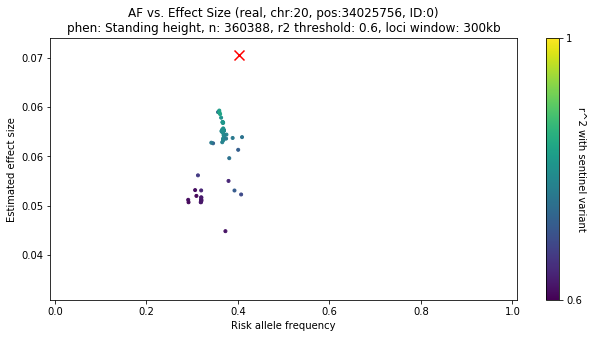

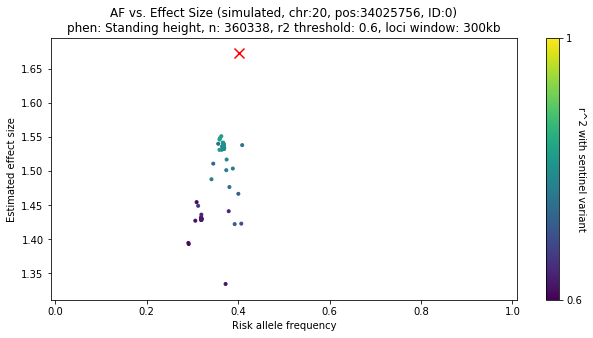

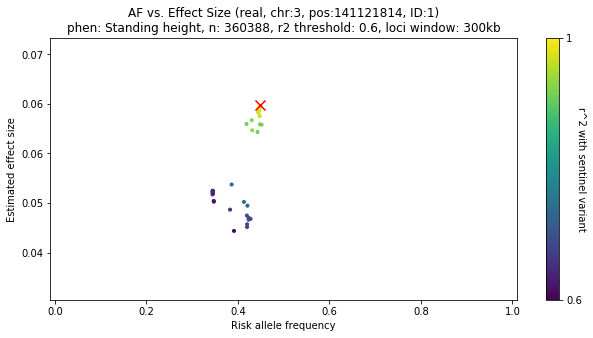

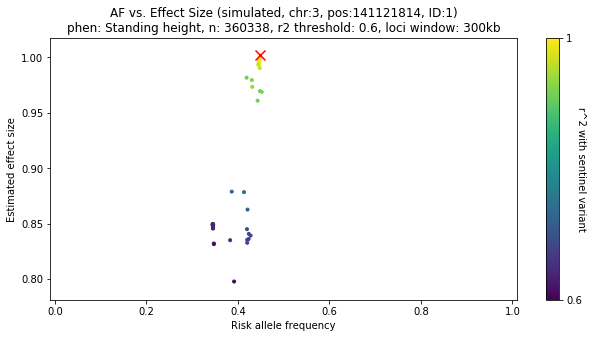

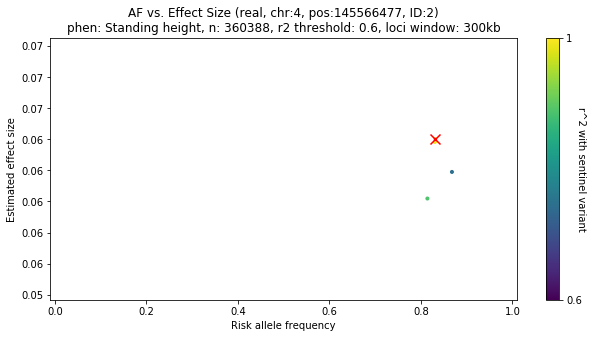

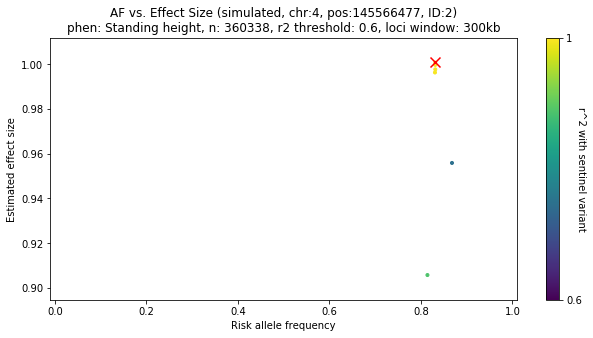

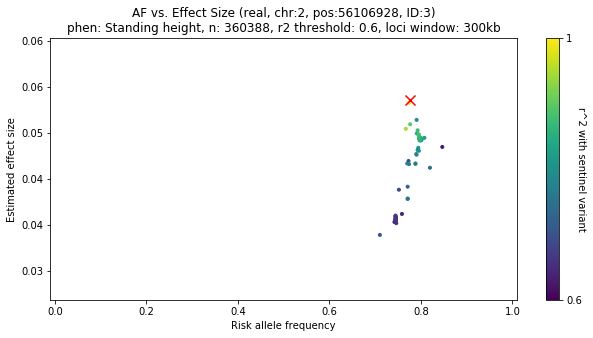

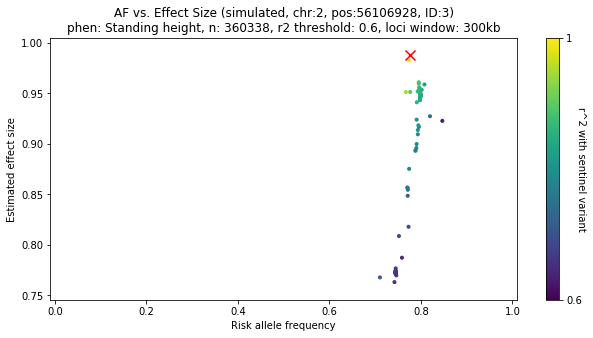

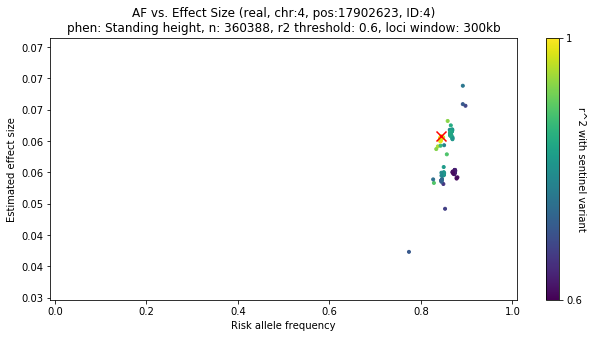

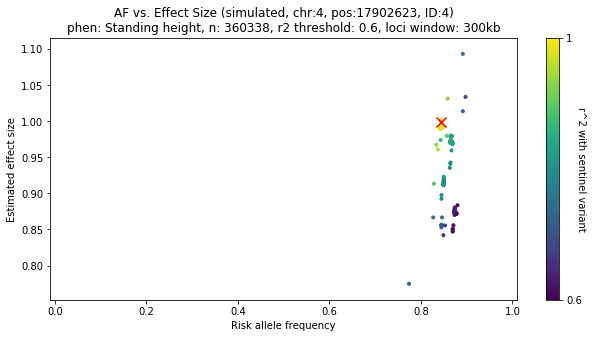

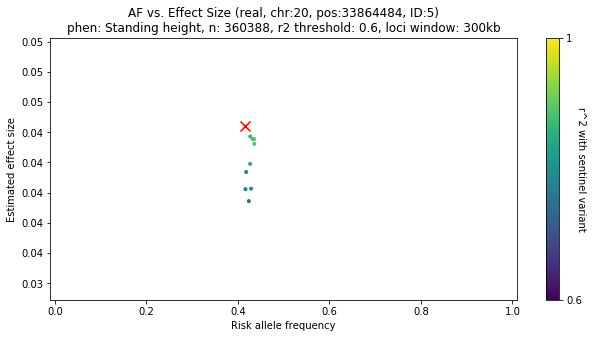

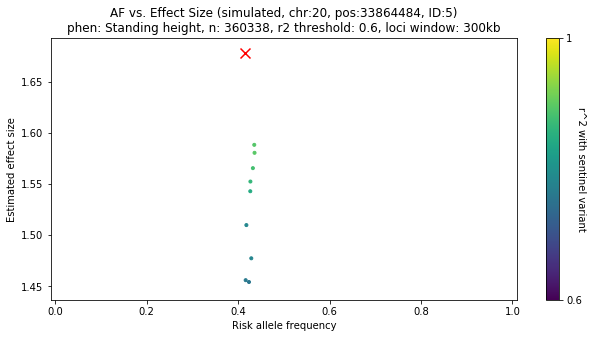

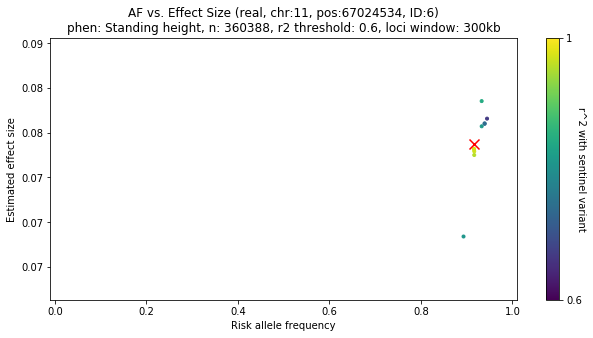

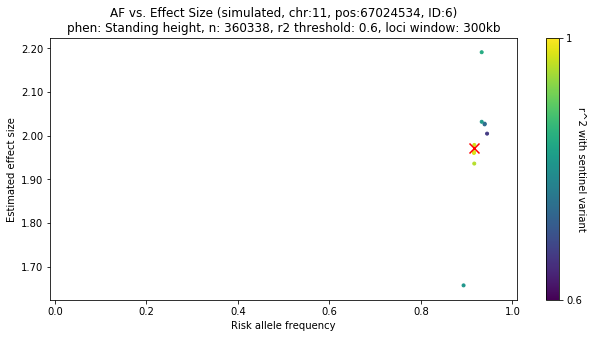

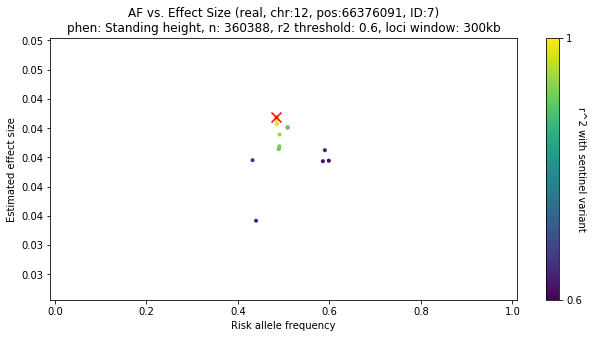

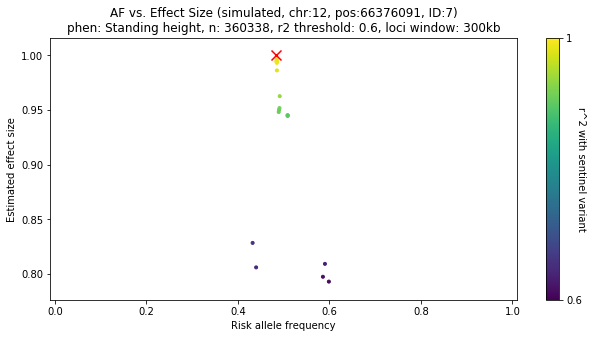

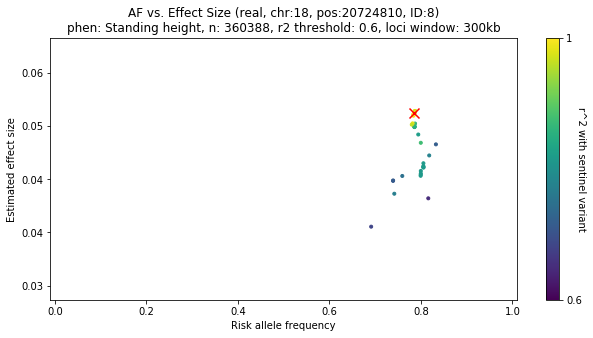

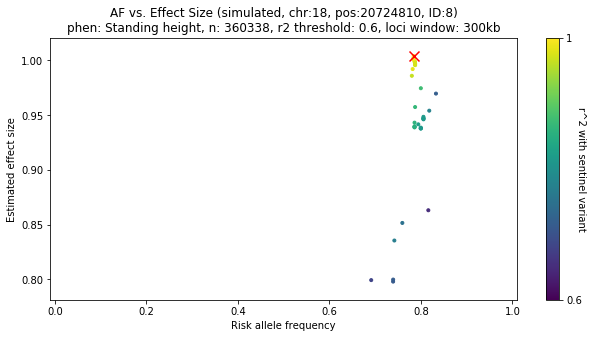

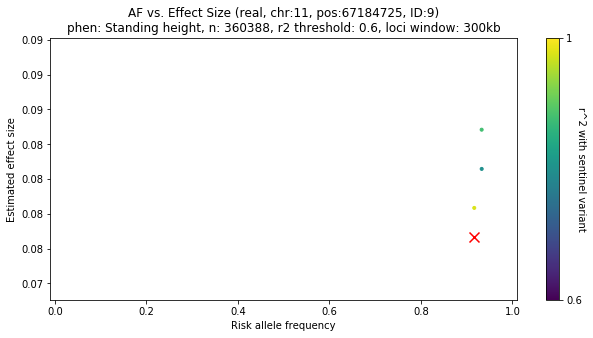

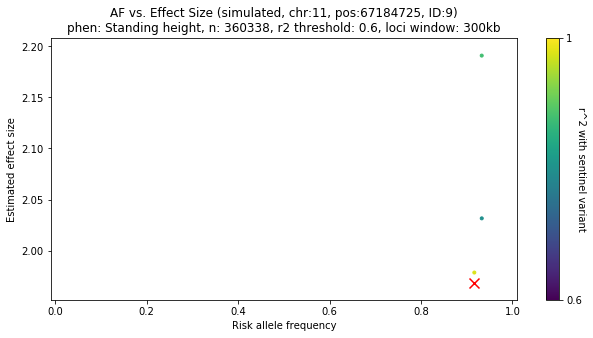

In [44]:
cm = plt.cm.get_cmap('viridis')
for loci_rank in range(n_top_loci):
    ch, pos = top_variants[loci_rank].astype(int)
    real_df = gwas_df[(gwas_df.ch==ch)&(gwas_df.pos>=pos-ld_window/2)&(gwas_df.pos<=pos+ld_window/2)&
                      (gwas_df.minor_AF>maf)&(gwas_df[f'r_{loci_rank}']**2>r2_threshold)]
    fig,ax=plt.subplots(figsize=(6*1.5,4*1.2))
    # ax.plot(real_df[~real_df.coding].real_raf,real_df[~real_df.coding].real_rbeta,'.',ms=4,c=colors[loci_rank%10])
    # ax.plot(real_df[real_df.coding].real_raf,real_df[real_df.coding].real_rbeta,'o',ms=10,markerfacecolor='none', markeredgewidth=0.75,c=colors[loci_rank%10])
    sc = ax.scatter(real_df[real_df.sim_beta==0].real_raf,real_df[real_df.sim_beta==0].real_rbeta,marker='.',c=real_df[real_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=r2_threshold,vmax=1)
    ax.scatter(real_df[real_df.sim_beta!=0].real_raf,real_df[real_df.sim_beta!=0].real_rbeta,marker='x',c='r',s=100)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb = plt.colorbar(sc)
    cb.set_ticks([r2_threshold, 1])
    cb.ax.set_yticklabels([str(r2_threshold),'1'])
    cb.set_label('r^2 with sentinel variant', rotation=270)
    plt.xlim([-0.01, 1.01])
    plt.xlabel('Risk allele frequency')
    plt.ylabel('Estimated effect size')
    plt.title(f'AF vs. Effect Size (real, chr:{ch}, pos:{pos}, ID:{loci_rank})\nphen: {phen_dict[phen][0]}, n: {phen_dict[phen][1]}, r2 threshold: {r2_threshold}{f", maf>{maf}" if maf!=0 else ""}, loci window: {int(ld_window/1e3)}kb')
    plt.tight_layout()
    fig.savefig(f'/home/nbaya/{phen}.raf_effectsize.r2_{r2_threshold}{f".maf{maf}" if maf>0 else ""}.loci_rank{loci_rank}.real.png',dpi=600)

    sim_df = gwas_df[(gwas_df.ch==ch)&(gwas_df.pos>=pos-ld_window/2)&(gwas_df.pos<=pos+ld_window/2)&
                     (gwas_df.minor_AF>maf)&(gwas_df[f'r_{loci_rank}']**2>r2_threshold)]
    fig,ax=plt.subplots(figsize=(6*1.5,4*1.2))
    # ax.plot(sim_df[~sim_df.coding].sim_raf,sim_df[~sim_df.coding].sim_rbeta,'.',ms=4,c=colors[loci_rank%10])
    # ax.plot(sim_df[sim_df.coding].sim_raf,sim_df[sim_df.coding].sim_rbeta,'o',ms=10,markerfacecolor='none', markeredgewidth=0.75,c=colors[loci_rank%10])
    if gwas_df[(gwas_df.ch==ch)&(gwas_df.pos==pos)].real_betahat.values[0]<0: #if beta for real data is negative, flip AF
        sc = ax.scatter(1-sim_df[sim_df.sim_beta==0].sim_raf,sim_df[sim_df.sim_beta==0].sim_rbeta,marker='.',c=sim_df[sim_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=r2_threshold,vmax=1)
        ax.scatter(1-sim_df[sim_df.sim_beta!=0].sim_raf,sim_df[sim_df.sim_beta!=0].sim_rbeta,marker='x',c='r',s=100)
    else:
        sc = ax.scatter(sim_df[sim_df.sim_beta==0].sim_raf,sim_df[sim_df.sim_beta==0].sim_rbeta,marker='.',c=sim_df[sim_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=r2_threshold,vmax=1)
        ax.scatter(sim_df[sim_df.sim_beta!=0].sim_raf,sim_df[sim_df.sim_beta!=0].sim_rbeta,marker='x',c='r',s=100)
#     sc = ax.scatter(sim_df[sim_df.sim_beta==0].sim_raf,sim_df[sim_df.sim_beta==0].sim_rbeta,marker='.',c=sim_df[sim_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=0,vmax=1)
#     ax.scatter(sim_df[sim_df.sim_beta!=0].sim_raf,sim_df[sim_df.sim_beta!=0].sim_rbeta,marker='x',c='r',s=100)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb= plt.colorbar(sc)
    cb.set_ticks([r2_threshold, 1])
    cb.ax.set_yticklabels([str(r2_threshold),'1'])
    cb.set_label('r^2 with sentinel variant', rotation=270)
    plt.xlim([-0.01, 1.01])
    plt.xlabel('Risk allele frequency')
    plt.ylabel('Estimated effect size')
    plt.title(f'AF vs. Effect Size (simulated, chr:{ch}, pos:{pos}, ID:{loci_rank})\nphen: {phen_dict[phen][0]}, n: {int(sim_df.n.mean())}, r2 threshold: {r2_threshold}{f", maf>{maf}" if maf!=0 else ""}, loci window: {int(ld_window/1e3)}kb')
    plt.tight_layout()
#     fig.savefig(f'/home/nbaya/{phen}.pval{pval}{f".maf{maf}" if maf>0 else ""}.loci_rank{loci_rank}.simulated.png',dpi=600)
    fig.savefig(f'/home/nbaya/{phen}.raf_effectsize.r2_{r2_threshold}{f".maf{maf}" if maf>0 else ""}.loci_rank{loci_rank}.simulated.png',dpi=600)

#### Plot RAF vs. variance explained for simulated & real data

In [42]:
gwas_df['sim_varexp'] = 2*(gwas_df.sim_raf)*(1-gwas_df.sim_raf)*gwas_df.sim_betahat**2

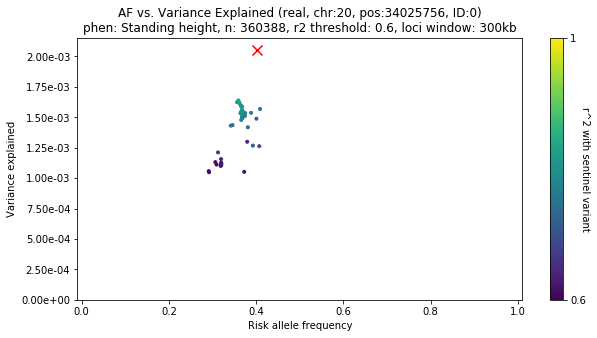

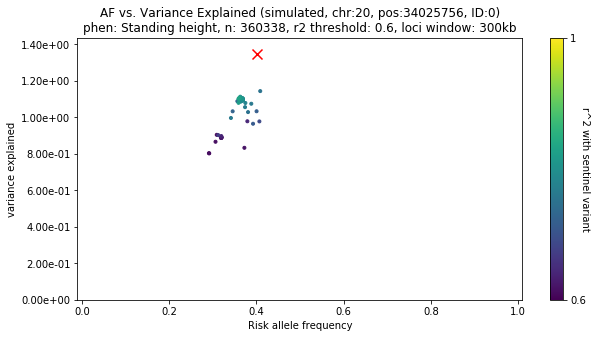

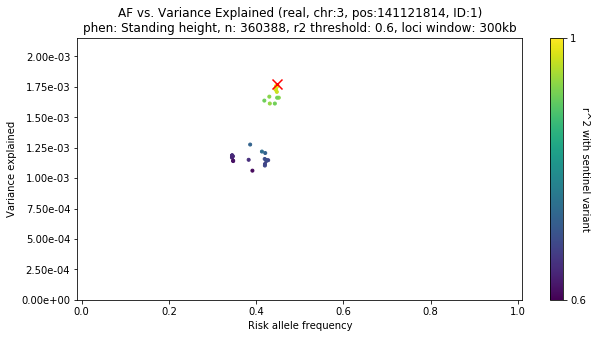

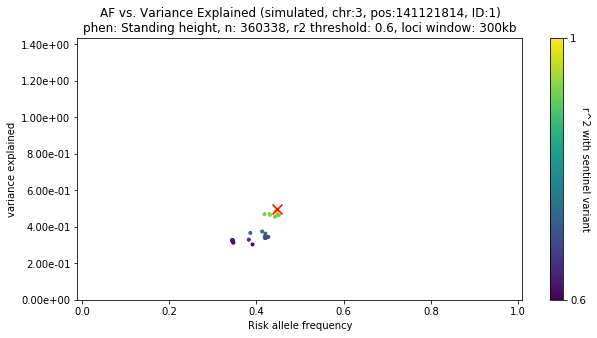

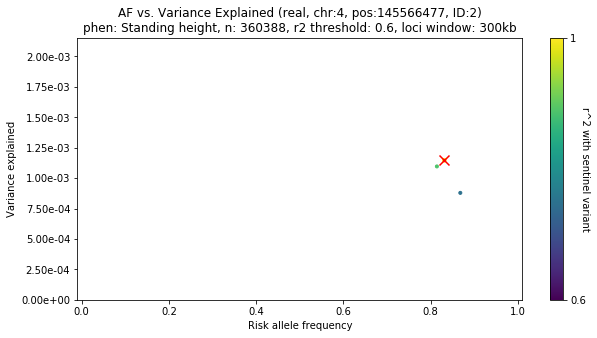

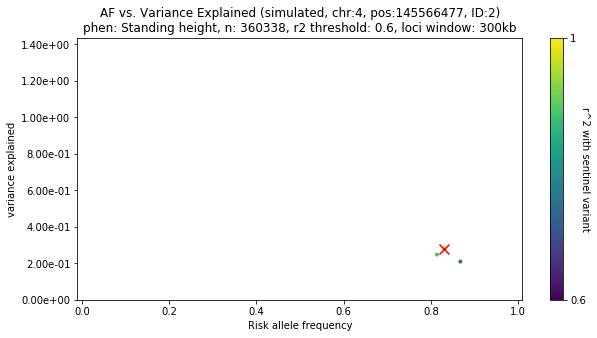

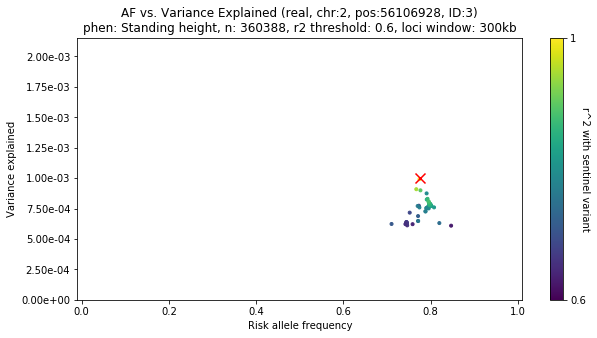

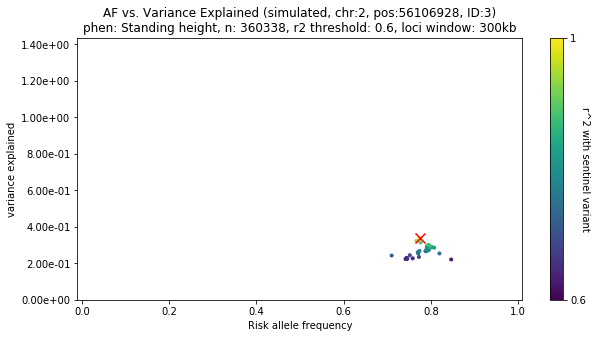

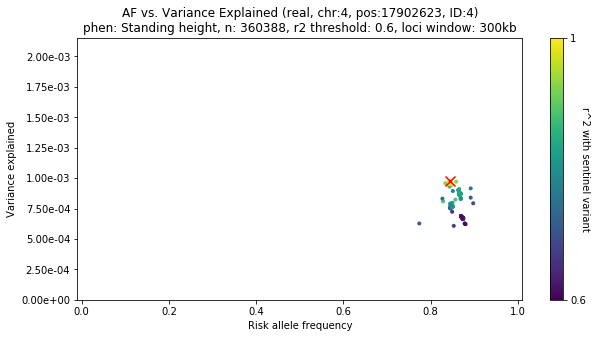

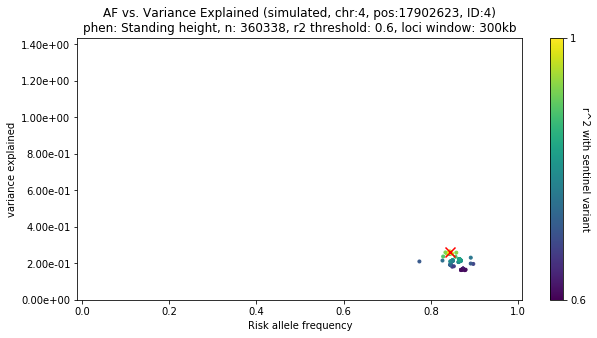

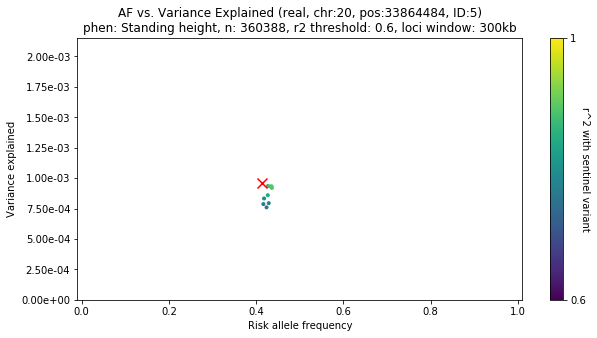

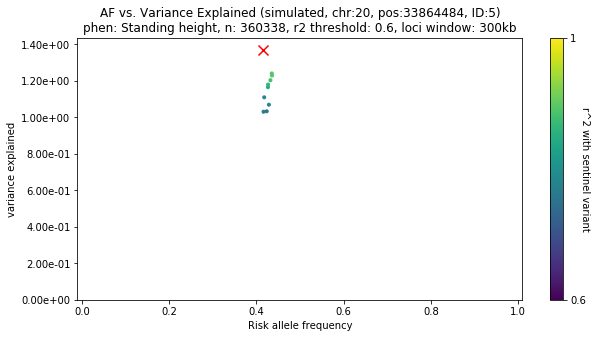

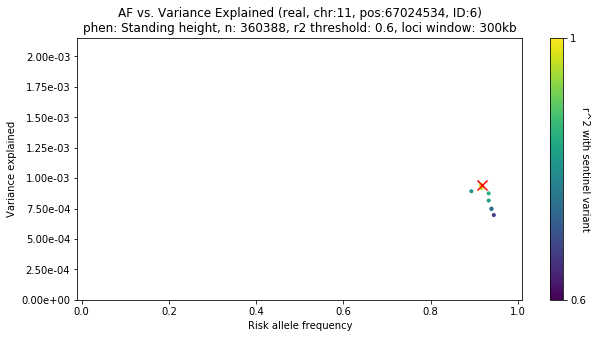

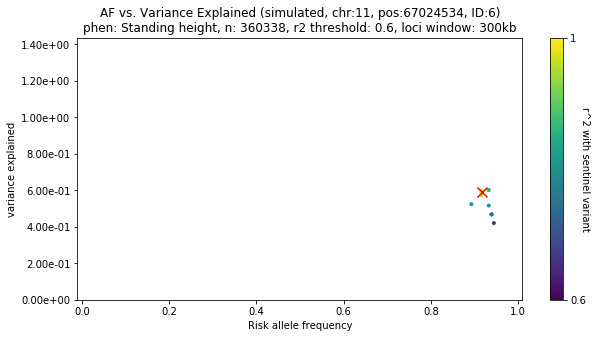

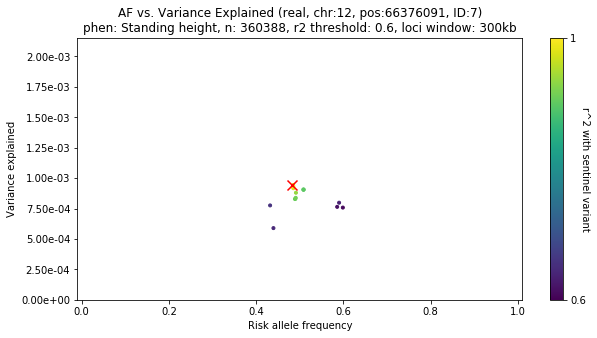

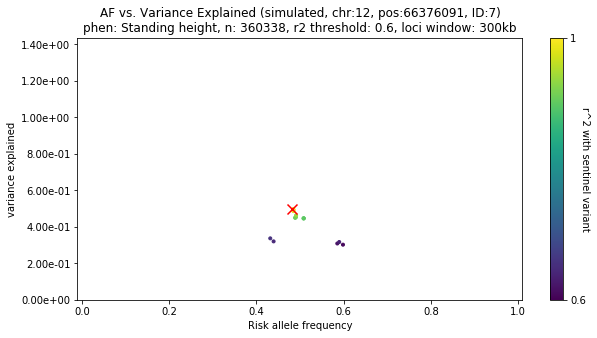

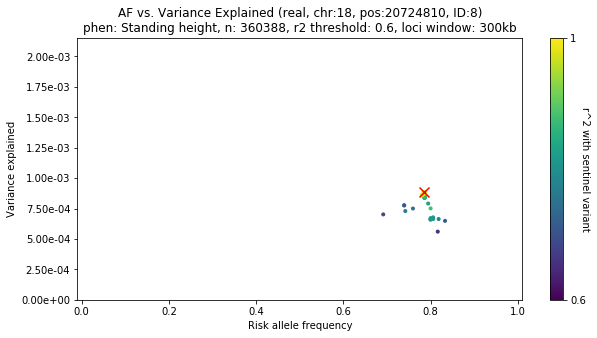

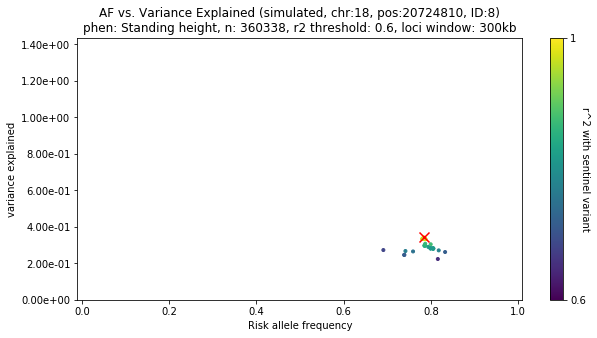

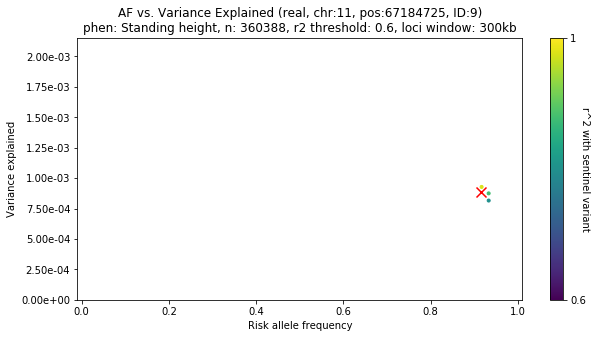

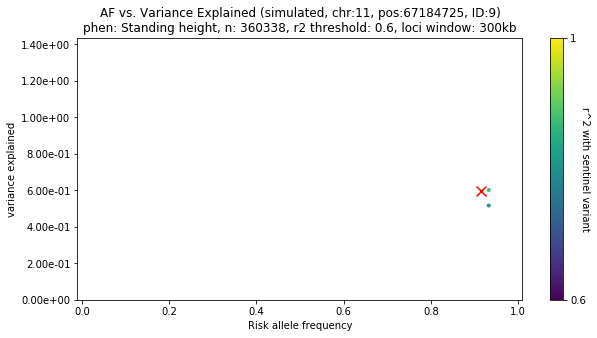

In [43]:
cm = plt.cm.get_cmap('viridis')
for loci_rank in range(n_top_loci):
    ch, pos = top_variants[loci_rank].astype(int)
    real_df = gwas_df[(gwas_df.ch==ch)&(gwas_df.pos>=pos-ld_window/2)&(gwas_df.pos<=pos+ld_window/2)&
                      (gwas_df.minor_AF>maf)&(gwas_df[f'r_{loci_rank}']**2>r2_threshold)]
    fig,ax=plt.subplots(figsize=(6*1.5,4*1.2))
    # ax.plot(real_df[~real_df.coding].real_raf,real_df[~real_df.coding].real_rbeta,'.',ms=4,c=colors[loci_rank%10])
    # ax.plot(real_df[real_df.coding].real_raf,real_df[real_df.coding].real_rbeta,'o',ms=10,markerfacecolor='none', markeredgewidth=0.75,c=colors[loci_rank%10])
    sc = ax.scatter(real_df[real_df.sim_beta==0].real_raf,real_df[real_df.sim_beta==0].real_varexp,marker='.',c=real_df[real_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=r2_threshold,vmax=1)
    ax.scatter(real_df[real_df.sim_beta!=0].real_raf,real_df[real_df.sim_beta!=0].real_varexp,marker='x',c='r',s=100)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    cb = plt.colorbar(sc)
    cb.set_ticks([r2_threshold, 1])
    cb.ax.set_yticklabels([str(r2_threshold),'1'])
    cb.set_label('r^2 with sentinel variant', rotation=270)
    plt.xlim([-0.01, 1.01])
    plt.ylim([0,gwas_df.real_varexp.max()*1.05])
    plt.xlabel('Risk allele frequency')
    plt.ylabel('Variance explained')
    plt.title(f'AF vs. Variance Explained (real, chr:{ch}, pos:{pos}, ID:{loci_rank})\nphen: {phen_dict[phen][0]}, n: {phen_dict[phen][1]}, r2 threshold: {r2_threshold}{f", maf>{maf}" if maf!=0 else ""}, loci window: {int(ld_window/1e3)}kb')
    plt.tight_layout()
#     fig.savefig(f'/home/nbaya/{phen}.pval{pval}{f".maf{maf}" if maf>0 else ""}.loci_rank{loci_rank}.real.png',dpi=600)
    fig.savefig(f'/home/nbaya/{phen}.raf_varexp.r2_{r2_threshold}{f".maf{maf}" if maf>0 else ""}.loci_rank{loci_rank}.real.png',dpi=600)


    sim_df = gwas_df[(gwas_df.ch==ch)&(gwas_df.pos>=pos-ld_window/2)&(gwas_df.pos<=pos+ld_window/2)&
                     (gwas_df.minor_AF>maf)&(gwas_df[f'r_{loci_rank}']**2>r2_threshold)]
    fig,ax=plt.subplots(figsize=(6*1.5,4*1.2))
    # ax.plot(sim_df[~sim_df.coding].sim_raf,sim_df[~sim_df.coding].sim_rbeta,'.',ms=4,c=colors[loci_rank%10])
    # ax.plot(sim_df[sim_df.coding].sim_raf,sim_df[sim_df.coding].sim_rbeta,'o',ms=10,markerfacecolor='none', markeredgewidth=0.75,c=colors[loci_rank%10])
    if gwas_df[(gwas_df.ch==ch)&(gwas_df.pos==pos)].real_betahat.values[0]<0: #if beta for real data is negative, flip AF
        sc = ax.scatter(1-sim_df[sim_df.sim_beta==0].sim_raf,sim_df[sim_df.sim_beta==0].sim_varexp,marker='.',c=sim_df[sim_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=r2_threshold,vmax=1)
        ax.scatter(1-sim_df[sim_df.sim_beta!=0].sim_raf,sim_df[sim_df.sim_beta!=0].sim_varexp,marker='x',c='r',s=100)
    else:
        sc = ax.scatter(sim_df[sim_df.sim_beta==0].sim_raf,sim_df[sim_df.sim_beta==0].sim_varexp,marker='.',c=sim_df[sim_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=r2_threshold,vmax=1)
        ax.scatter(sim_df[sim_df.sim_beta!=0].sim_raf,sim_df[sim_df.sim_beta!=0].sim_varexp,marker='x',c='r',s=100)
#     sc = ax.scatter(sim_df[sim_df.sim_beta==0].sim_raf,sim_df[sim_df.sim_beta==0].sim_rbeta,marker='.',c=sim_df[sim_df.sim_beta==0][f'r_{loci_rank}']**2,cmap=cm,vmin=0,vmax=1)
#     ax.scatter(sim_df[sim_df.sim_beta!=0].sim_raf,sim_df[sim_df.sim_beta!=0].sim_rbeta,marker='x',c='r',s=100)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    cb= plt.colorbar(sc)
    cb.set_ticks([r2_threshold, 1])
    cb.ax.set_yticklabels([str(r2_threshold),'1'])
    cb.set_label('r^2 with sentinel variant', rotation=270)
    plt.xlim([-0.01, 1.01])
    plt.ylim([0,gwas_df.sim_varexp.max()*1.05])
    plt.xlabel('Risk allele frequency')
    plt.ylabel('variance explained')
    plt.title(f'AF vs. Variance Explained (simulated, chr:{ch}, pos:{pos}, ID:{loci_rank})\nphen: {phen_dict[phen][0]}, n: {int(sim_df.n.mean())}, r2 threshold: {r2_threshold}{f", maf>{maf}" if maf!=0 else ""}, loci window: {int(ld_window/1e3)}kb')
    plt.tight_layout()
#     fig.savefig(f'/home/nbaya/{phen}.pval{pval}{f".maf{maf}" if maf>0 else ""}.loci_rank{loci_rank}.simulated.png',dpi=600)
    fig.savefig(f'/home/nbaya/{phen}.raf_varexp.r2_{r2_threshold}{f".maf{maf}" if maf>0 else ""}.loci_rank{loci_rank}.simulated.png',dpi=600)

#### Plot distribution of signed differences

In [121]:
phen = '50_irnt'
n_top_loci = 10
ld_window=300e3
r2_threshold = 0.9

In [112]:
gwas = hl.import_table(wd+phen+f'.gwas.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.tsv.bgz',impute=True,force_bgz=True)
gwas_df = gwas.to_pandas()
top_variants = gwas_df[gwas_df.sim_beta==1].sort_values(by='real_pval',ascending=True)[['ch','pos']].values

2019-08-08 12:53:17 Hail: INFO: Reading table to impute column types
2019-08-08 12:53:18 Hail: INFO: Finished type imputation
  Loading column 'alleles' as type 'str' (imputed)
  Loading column 'alt_AF' as type 'float64' (imputed)
  Loading column 'ch' as type 'int32' (imputed)
  Loading column 'coding' as type 'bool' (imputed)
  Loading column 'loci_rank' as type 'float64' (imputed)
  Loading column 'locus.contig' as type 'int32' (imputed)
  Loading column 'locus.position' as type 'int32' (imputed)
  Loading column 'minor_AF' as type 'float64' (imputed)
  Loading column 'minor_allele' as type 'str' (imputed)
  Loading column 'n' as type 'int32' (imputed)
  Loading column 'pos' as type 'int32' (imputed)
  Loading column 'real_betahat' as type 'float64' (imputed)
  Loading column 'real_pval' as type 'float64' (imputed)
  Loading column 'real_raf' as type 'float64' (imputed)
  Loading column 'real_rbeta' as type 'float64' (imputed)
  Loading column 'real_varexp' as type 'float64' (impute

In [122]:
diffs = []
for loci_rank in range(n_top_loci):
    ch, pos = top_variants[loci_rank].astype(int)
    sentinel_raf = gwas_df[(gwas_df.ch==ch)&(gwas_df.pos==pos)].real_raf.values[0]
    real_df = gwas_df[(gwas_df.ch==ch)&(gwas_df.pos>=pos-ld_window/2)&(gwas_df.pos<=pos+ld_window/2)&
                      (gwas_df.minor_AF>maf)&(gwas_df[f'r_{loci_rank}']**2>r2_threshold)&(gwas_df.pos!=pos)].copy()
    diffs = diffs + (real_df.real_raf - sentinel_raf).tolist()
diffs = np.asarray(diffs)
    

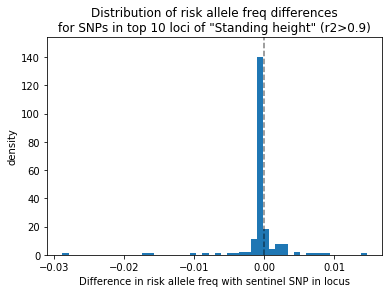

In [123]:
n, bins, patches = plt.hist(diffs,50)
plt.plot([0,0],[0,max(n)*1.1],'k--',alpha=0.5)
plt.ylim([0,max(n)*1.1])
plt.title(f'Distribution of risk allele freq differences\nfor SNPs in top {n_top_loci} loci of "{phen_dict[phen][0]}" (r2>{r2_threshold})')
plt.xlabel('Difference in risk allele freq with sentinel SNP in locus')
plt.ylabel('density')
plt.savefig(f'/home/nbaya/{phen}.raf_differences.r2_{r2_threshold}.top{n_top_loci}loci.real.png',dpi=600)

In [236]:
# hl.Table.from_pandas(gwas_df).export(wd+phen+f'.gwas.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.tsv.bgz')

2019-07-26 15:30:09 Hail: INFO: merging 4 files totalling 614.5K...
2019-07-26 15:30:10 Hail: INFO: while writing:
    gs://nbaya/smiles/50_irnt.gwas.top10loci.ldwindow300kb.tsv.bgz
  merge time: 678.244ms


Text(0, 0.5, 'Estimated effect size')

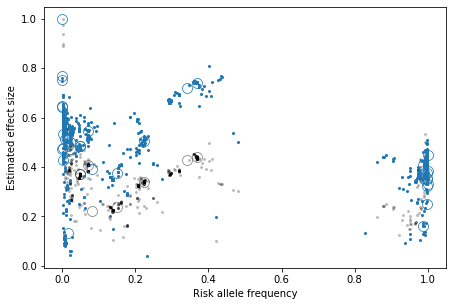

In [121]:
real_df = gwas_df[(gwas_df.loci_rank==loci_rank)&(gwas_df.real_pval<pval_threshold)&(gwas_df.minor_AF>maf)]
sim_df = gwas_df[(gwas_df.loci_rank==loci_rank)&(gwas_df.sim_pval<pval_threshold)&(gwas_df.minor_AF>maf)]
fig,ax=plt.subplots(figsize=(6*1.2,4*1.2))
ax.plot(real_df[~real_df.coding].real_raf,real_df[~real_df.coding].real_rbeta/real_df.real_rbeta.max(),'.',ms=4,c='k',alpha=0.2)
ax.plot(real_df[real_df.coding].real_raf,real_df[real_df.coding].real_rbeta/real_df.real_rbeta.max(),'o',ms=10,markerfacecolor='none', markeredgewidth=0.75,c='k',alpha=0.5)
ax.plot(sim_df[~sim_df.coding].sim_raf,sim_df[~sim_df.coding].sim_rbeta/sim_df.sim_rbeta.max(),'.',ms=4,c=colors[loci_rank%10])
ax.plot(sim_df[sim_df.coding].sim_raf,sim_df[sim_df.coding].sim_rbeta/sim_df.sim_rbeta.max(),'o',ms=10,markerfacecolor='none', markeredgewidth=0.75,c=colors[loci_rank%10])
plt.xlabel('Risk allele frequency')
plt.ylabel('Estimated effect size')

### Old version

In [19]:
mt_all_loci = hl.read_matrix_table(f'gs://nbaya/smiles/{phen}.simulation.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.mt')

In [24]:
gwas = hl.read_table(wd+phen+f'.gwas.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.ht')

In [31]:
ss = hl.import_table(wd+f'data/{phen}.gwas.imputed_v3.both_sexes.coding.tsv.bgz',impute=True)

2019-07-24 19:00:45 Hail: INFO: Reading table to impute column types
2019-07-24 19:01:02 Hail: INFO: Finished type imputation
  Loading column 'variant' as type 'str' (imputed)
  Loading column 'minor_allele' as type 'str' (imputed)
  Loading column 'minor_AF' as type 'float64' (imputed)
  Loading column 'low_confidence_variant' as type 'bool' (imputed)
  Loading column 'n_complete_samples' as type 'int32' (imputed)
  Loading column 'AC' as type 'float64' (imputed)
  Loading column 'ytx' as type 'float64' (imputed)
  Loading column 'beta' as type 'float64' (imputed)
  Loading column 'se' as type 'float64' (imputed)
  Loading column 'tstat' as type 'float64' (imputed)
  Loading column 'pval' as type 'float64' (imputed)
  Loading column 'coding' as type 'bool' (imputed)


In [44]:
# gwas = gwas.key_by()
# gwas = gwas.annotate(variant = locus)
ss = ss.annotate(locus = hl.parse_locus(ss.variant.split(':')[0]+':'+ss.variant.split(':')[1]),
                alleles = ss.variant.split(':')[2:])

In [45]:
ss = ss.key_by(ss.locus,ss.alleles)

In [46]:
gwas = gwas.annotate(minor_allele = ss[gwas.locus,gwas.alleles].minor_allele,
                     minor_AF = ss[gwas.locus,gwas.alleles].minor_AF,)

In [47]:
gwas.show()

2019-07-24 19:19:51 Hail: INFO: Coerced sorted dataset
2019-07-24 19:24:23 Hail: INFO: Coerced sorted dataset


KeyboardInterrupt: 

In [48]:
gwas.write(wd+phen+f'.gwas.top{n_top_loci}loci.ldwindow{int(ld_window/1e3)}kb.ht',overwrite=True)

2019-07-24 19:38:15 Hail: INFO: Coerced sorted dataset
2019-07-24 19:42:55 Hail: INFO: Coerced sorted dataset


FatalError: FileNotFoundException: Item not found: 'gs://nbaya/smiles/50_irnt.gwas.top10loci.ldwindow300kb.ht/rows/parts/part-0000-4-0-0-6e37297d-c98a-a7fc-015c-ea27061081a8'. If you enabled STRICT generation consistency, it is possible that the live version is still available but the intended generation is deleted.

Java stack trace:
org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 38.0 failed 20 times, most recent failure: Lost task 0.19 in stage 38.0 (TID 11816, ukbb-nb2-w-1.c.ukbb-round2.internal, executor 56): java.io.FileNotFoundException: Item not found: 'gs://nbaya/smiles/50_irnt.gwas.top10loci.ldwindow300kb.ht/rows/parts/part-0000-4-0-0-6e37297d-c98a-a7fc-015c-ea27061081a8'. If you enabled STRICT generation consistency, it is possible that the live version is still available but the intended generation is deleted.
	at com.google.cloud.hadoop.repackaged.gcs.com.google.cloud.hadoop.gcsio.GoogleCloudStorageExceptions.getFileNotFoundException(GoogleCloudStorageExceptions.java:38)
	at com.google.cloud.hadoop.repackaged.gcs.com.google.cloud.hadoop.gcsio.GoogleCloudStorageImpl.open(GoogleCloudStorageImpl.java:631)
	at com.google.cloud.hadoop.repackaged.gcs.com.google.cloud.hadoop.gcsio.GoogleCloudStorageFileSystem.open(GoogleCloudStorageFileSystem.java:322)
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopFSInputStream.<init>(GoogleHadoopFSInputStream.java:77)
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystemBase.open(GoogleHadoopFileSystemBase.java:740)
	at org.apache.hadoop.fs.FileSystem.open(FileSystem.java:914)
	at is.hail.io.fs.HadoopFS.open(HadoopFS.scala:105)
	at is.hail.io.fs.HadoopFS.unsafeReader(HadoopFS.scala:416)
	at is.hail.HailContext$$anon$1.compute(HailContext.scala:543)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1890)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2111)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at is.hail.sparkextras.ContextRDD.collect(ContextRDD.scala:196)
	at is.hail.utils.richUtils.RichContextRDD.writePartitions(RichContextRDD.scala:56)
	at is.hail.io.RichContextRDDRegionValue$.writeRows$extension(RowStore.scala:1995)
	at is.hail.rvd.RVD.write(RVD.scala:740)
	at is.hail.expr.ir.TableValue.write(TableValue.scala:96)
	at is.hail.expr.ir.TableNativeWriter.apply(TableWriter.scala:25)
	at is.hail.expr.ir.Interpret$.apply(Interpret.scala:761)
	at is.hail.expr.ir.Interpret$.apply(Interpret.scala:88)
	at is.hail.expr.ir.CompileAndEvaluate$$anonfun$1.apply(CompileAndEvaluate.scala:32)
	at is.hail.utils.ExecutionTimer.time(ExecutionTimer.scala:20)
	at is.hail.expr.ir.CompileAndEvaluate$.apply(CompileAndEvaluate.scala:32)
	at is.hail.backend.Backend.execute(Backend.scala:86)
	at is.hail.backend.Backend.executeJSON(Backend.scala:92)
	at sun.reflect.GeneratedMethodAccessor57.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)

java.io.FileNotFoundException: Item not found: 'gs://nbaya/smiles/50_irnt.gwas.top10loci.ldwindow300kb.ht/rows/parts/part-0000-4-0-0-6e37297d-c98a-a7fc-015c-ea27061081a8'. If you enabled STRICT generation consistency, it is possible that the live version is still available but the intended generation is deleted.
	at com.google.cloud.hadoop.repackaged.gcs.com.google.cloud.hadoop.gcsio.GoogleCloudStorageExceptions.getFileNotFoundException(GoogleCloudStorageExceptions.java:38)
	at com.google.cloud.hadoop.repackaged.gcs.com.google.cloud.hadoop.gcsio.GoogleCloudStorageImpl.open(GoogleCloudStorageImpl.java:631)
	at com.google.cloud.hadoop.repackaged.gcs.com.google.cloud.hadoop.gcsio.GoogleCloudStorageFileSystem.open(GoogleCloudStorageFileSystem.java:322)
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopFSInputStream.<init>(GoogleHadoopFSInputStream.java:77)
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystemBase.open(GoogleHadoopFileSystemBase.java:740)
	at org.apache.hadoop.fs.FileSystem.open(FileSystem.java:914)
	at is.hail.io.fs.HadoopFS.open(HadoopFS.scala:105)
	at is.hail.io.fs.HadoopFS.unsafeReader(HadoopFS.scala:416)
	at is.hail.HailContext$$anon$1.compute(HailContext.scala:543)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)




Hail version: 0.2.16-6da0d3571629
Error summary: FileNotFoundException: Item not found: 'gs://nbaya/smiles/50_irnt.gwas.top10loci.ldwindow300kb.ht/rows/parts/part-0000-4-0-0-6e37297d-c98a-a7fc-015c-ea27061081a8'. If you enabled STRICT generation consistency, it is possible that the live version is still available but the intended generation is deleted.

In [43]:
gwas.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'sim_beta': bool 
    'real_rbeta': float64 
    'real_raf': float64 
    'real_pval': float64 
    'coding': bool 
    'real_varexp': float64 
    'n': int32 
    'sum_x': float64 
    'y_transpose_x': float64 
    'beta': float64 
    'standard_error': float64 
    't_stat': float64 
    'p_value': float64 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [27]:
gwas_df = gwas.to_pandas()

In [28]:
gwas_df

,locus.contig,locus.position,alleles,sim_beta,real_rbeta,real_raf,real_pval,coding,real_varexp,n,sum_x,y_transpose_x,beta,standard_error,t_stat,p_value
0,2,55957006,"[TAATTA, T]",False,0.025541,0.102110,1.725100e-20,False,1.196182e-04,360338,73587.756863,5.708425e+05,-0.148849,0.008272,-17.993735,2.347010e-72
1,2,55957095,"[G, A]",False,0.013765,0.043661,8.024000e-04,False,1.582297e-05,360338,31464.105882,2.445178e+05,-0.124487,0.012343,-10.085285,6.464982e-24
2,2,55957799,"[C, T]",False,0.015299,0.006496,1.499600e-01,False,3.021007e-06,360338,4681.749020,3.590661e+04,-0.235167,0.031941,-7.362456,1.809392e-13
3,2,55957969,"[A, G]",False,0.003097,0.976344,5.706400e-01,False,4.430539e-07,360338,17047.443137,1.317095e+05,-0.165228,0.016414,-10.065979,7.867593e-24
4,2,55958140,"[T, G]",False,0.013045,0.978728,2.409600e-02,False,7.085794e-06,360338,15332.113725,1.255886e+05,0.313875,0.017378,18.062084,6.826924e-73
5,2,55958153,"[C, T]",False,0.023307,0.969615,1.637100e-06,False,3.200820e-05,360338,21897.541176,1.772670e+05,0.215786,0.014612,14.767624,2.449379e-49
6,2,55958180,"[TCTTC, T]",False,0.025517,0.971679,6.436000e-07,False,3.583609e-05,360338,20410.101961,1.652358e+05,0.223707,0.015407,14.520311,9.294887e-48
7,2,55958181,"[CTTCT, C]",False,0.024122,0.969986,1.037500e-06,False,3.388020e-05,360338,21628.917647,1.750369e+05,0.217420,0.014842,14.648658,1.419040e-48
8,2,55958321,"[G, C]",False,0.025231,0.101820,3.696400e-20,False,1.164382e-04,360338,73380.803922,5.692222e+05,-0.147742,0.008245,-17.919939,8.856713e-72
9,2,55958351,"[AC, A]",False,0.005813,0.016560,3.782100e-01,False,1.100548e-06,360338,11933.905882,9.165140e+04,-0.230654,0.019827,-11.633522,2.819811e-31


In [30]:
ss = gwas_df.rename(columns={'locus.contig':'ch','locus.position':'pos'})
ss_ls = [None]*n_top_loci #list of dataframes with top loci
ss_tmp = ss.copy() #dataframe from which top loci will be removed
ss_keep = ss[[False]*len(ss)]
i = 0 
print(f'filtering to top {n_top_loci} loci with window of {ld_window/1e3} kb')
while len(ss_tmp)>0 and i<n_top_loci:
    ch, pos = ss_tmp[ss_tmp.pval==ss_tmp.pval.min()][['chr','pos']].values[0]
    top_variants.append(f'{ch}:{pos}')
    ss_w_top_locus = ss_tmp[(ss_tmp['chr']==ch)&(ss_tmp['pos']>=pos-ld_window/2)&(ss_tmp['pos']<=pos+ld_window/2)].copy() #extract rows around most significant hit
    ss_w_top_locus['loci_rank'] = i
    ss_keep = ss_keep.append(ss_w_top_locus)
    ss_tmp = ss_tmp[~((ss_tmp['chr']==ch)&(ss_tmp['pos']>=pos-ld_window/2)&(ss_tmp['pos']<=pos+ld_window/2))].copy() #keep rows not around most significant hit
    i += 1
ss = ss_keep
ss = ss.sort_values(by='index') #unnecessary step, but restores the order of variants

filtering to top 10 loci with window of 300.0 kb


AttributeError: 'DataFrame' object has no attribute 'pval'

In [36]:
ld_locus = hl.row_correlation(mt_locus.mt_all_loci).to_numpy()

2019-07-21 15:44:42 Hail: INFO: Wrote all 88 blocks of 326 x 359933 matrix with block size 4096.


In [64]:
ld = ld_locus[sentinel_idx]

In [66]:
ld = np.squeeze(ld)

In [35]:
mt_locus.varid.show()

locus,alleles,varid
locus<GRCh37>,array<str>,str
16:53656135,"[""G"",""C""]","""16:53656135_G_C"""
16:53657949,"[""G"",""C""]","""16:53657949_G_C"""
16:53658724,"[""T"",""C""]","""16:53658724_T_C"""
16:53661761,"[""T"",""TAC""]","""16:53661761_T_TAC"""
16:53662895,"[""G"",""GGT""]","""16:53662895_G_GGT"""
16:53664458,"[""A"",""C""]","""16:53664458_A_C"""
16:53664934,"[""C"",""T""]","""16:53664934_C_T"""
16:53665585,"[""TAATAA"",""T""]","""16:53665585_TAATAA_T"""
16:53668653,"[""C"",""T""]","""16:53668653_C_T"""


In [8]:
gwas_locus = hl.read_table(wd+phen+f'.gwas_locus.maf0.pval{pval}.ht')

In [9]:
gwas_df = gwas_locus.to_pandas()

In [78]:
merged.columns.values

array(['AC', 'alt_af', 'beta_x', 'chr', 'coding', 'index', 'loci_rank',
       'low_confidence_variant', 'minor_AF', 'minor_allele', 'n_x', 'pos',
       'pval', 'raf', 'rbeta', 'ref', 'se', 'tstat', 'var_exp',
       'variant.locus.contig', 'variant.locus.position',
       'variant.alleles', 'ytx', 'locus.contig_x', 'locus.position_x',
       'alleles_x', 'locus.contig_y', 'locus.position_y', 'alleles_y',
       'n_y', 'sum_x', 'y_transpose_x', 'beta_y', 'standard_error',
       't_stat', 'p_value', 'rbeta_x', 'rbeta_y'], dtype=object)

In [12]:
gwas_df.columns.values

array(['locus.contig', 'locus.position', 'alleles', 'n', 'sum_x',
       'y_transpose_x', 'beta', 'standard_error', 't_stat', 'p_value'],
      dtype=object)

In [13]:
merged = ss.merge(gwas_df,left_on='variant.locus.position',right_on='locus.position')

In [14]:
merged.loc[merged.beta_x>0,'raf'] = merged.loc[merged.beta_x>0,'alt_af']
merged.loc[merged.beta_x<0,'raf'] = 1-merged.loc[merged.beta_x<0,'alt_af']
merged['rbeta_x'] = np.abs(merged['beta_x'])
merged['rbeta_y'] = np.abs(merged['beta_y'])

In [80]:
merged = merged.sort_values(by='variant.locus.position')
merged['ld'] = ld

In [81]:
merged['ld'][sentinel_idx]

112    1.0
Name: ld, dtype: float64

In [79]:
merged['pval'][sentinel_idx]

112    2.827200e-206
Name: pval, dtype: float64

In [99]:
merged[merged.pos==pos]['rbeta'].max()

0.072818

/opt/conda/default/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/default/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


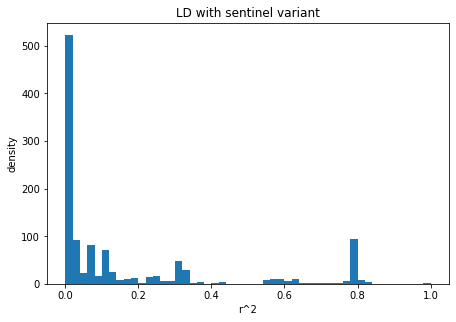

In [201]:
fig,ax=plt.subplots(figsize=(6*1.2,4*1.2))
ax.hist(gwas_df.r**2,50)
plt.xlabel('r^2')
plt.ylabel('density')
plt.title('LD with sentinel variant')
fig=plt.gcf()
fig.savefig(f'/home/nbaya/{phen}.pval{pval}.loci_rank0.ld.png',dpi=600)

In [63]:
ld.min()

-0.32904078631025396

In [ ]:
fig,ax=plt.subplots(figsize=(6*1.2,4*1.2))
ax.scatter(merged[merged.pos!=pos].raf,merged[merged.pos!=pos].rbeta_y,c=merged[merged.pos!=pos].ld**2,cmap='Blues',vmin=-0.5,vmax=1)
ax.scatter(merged[merged.pos==pos].raf,merged[merged.pos==pos].rbeta_y,c='red',marker='x',s=100)
plt.xlabel('Risk allele frequency')
plt.ylabel('Estimated effect size')
plt.title(f'AF vs. Effect Size (simulated)\nphen: BMI, n: 359933, pval threshold: {pval}, loci window: {int(ld_window/1e3)}kb')
fig=plt.gcf()
fig.savefig(f'/home/nbaya/{phen}.pval{pval}.loci_rank0.simulated.png',dpi=600)

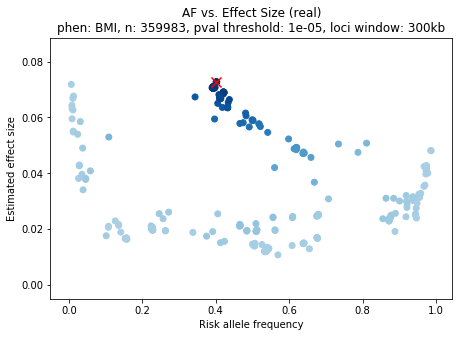

In [115]:
fig,ax=plt.subplots(figsize=(6*1.2,4*1.2))
ax.scatter(merged[merged.pos!=pos].raf,merged[merged.pos!=pos].rbeta_x,c=merged[merged.pos!=pos].ld**2,cmap='Blues',vmin=-0.5,vmax=1)
ax.scatter(merged[merged.pos==pos].raf,merged[merged.pos==pos].rbeta_x,c='red',marker='x',s=100)
plt.xlabel('Risk allele frequency')
plt.ylabel('Estimated effect size')
plt.title(f'AF vs. Effect Size (real)\nphen: BMI, n: 359983, pval threshold: {pval}, loci window: {int(ld_window/1e3)}kb')
fig=plt.gcf()
fig.savefig(f'/home/nbaya/{phen}.pval{pval}.loci_rank0.real.png',dpi=600)

In [116]:
merged['var_exp_y'] = 2*(merged.raf)*(1-merged.raf)*merged.rbeta_y**2

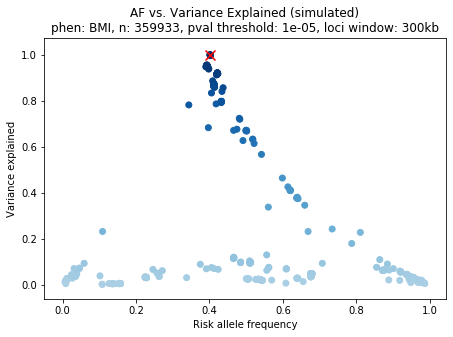

In [117]:
fig,ax=plt.subplots(figsize=(6*1.2,4*1.2))
ax.scatter(merged[merged.pos!=pos].raf,merged[merged.pos!=pos].var_exp_y,c=merged[merged.pos!=pos].ld**2,cmap='Blues',vmin=-0.5,vmax=1)
ax.scatter(merged[merged.pos==pos].raf,merged[merged.pos==pos].var_exp_y,c='red',marker='x',s=100)
plt.xlabel('Risk allele frequency')
plt.ylabel('Variance explained')
plt.title(f'AF vs. Variance Explained (simulated)\nphen: BMI, n: 359933, pval threshold: {pval}, loci window: {int(ld_window/1e3)}kb')
fig=plt.gcf()
fig.savefig(f'/home/nbaya/{phen}.pval{pval}.loci_rank0.raf_varianceexplained.simulated.png',dpi=600)

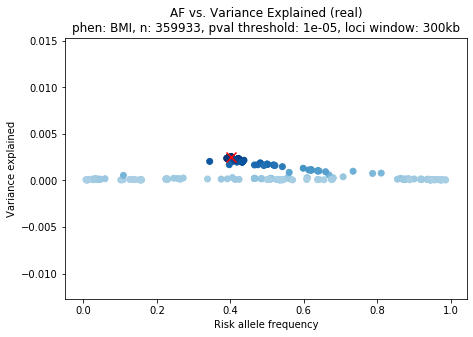

In [118]:
fig,ax=plt.subplots(figsize=(6*1.2,4*1.2))
ax.scatter(merged[merged.pos!=pos].raf,merged[merged.pos!=pos].var_exp,c=merged[merged.pos!=pos].ld**2,cmap='Blues',vmin=-0.5,vmax=1)
ax.scatter(merged[merged.pos==pos].raf,merged[merged.pos==pos].var_exp,c='red',marker='x',s=100)

plt.xlabel('Risk allele frequency')
plt.ylabel('Variance explained')
plt.title(f'AF vs. Variance Explained (real)\nphen: BMI, n: 359933, pval threshold: {pval}, loci window: {int(ld_window/1e3)}kb')
fig=plt.gcf()
fig.savefig(f'/home/nbaya/{phen}.pval{pval}.loci_rank0.raf_varianceexplained.real.png',dpi=600)

## Run simulation

In [3]:
get_top_loci=True
n_top_loci = 10
ld_window = 300e3
highlight_coding = True
ld_clumping=False

In [4]:
# get table of genotypes and covariates
mt0 = hl.read_matrix_table(f'gs://nbaya/split/ukb31063.qc_pos_variants.gwas_samples_repart.mt')
withdrawn = hl.import_table('gs://nbaya/w31063_20181016.csv',missing='',no_header=True).key_by('f0')
mt0 = mt0.filter_cols(hl.is_defined(withdrawn[mt0.s]),keep=False) #Remove withdrawn samples

Initializing Spark and Hail with default parameters...
using hail jar at /opt/conda/default/lib/python3.6/site-packages/hail/hail-all-spark.jar
Running on Apache Spark version 2.4.3
SparkUI available at http://ukbb-nb1-m.c.ukbb-round2.internal:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.16-6da0d3571629
LOGGING: writing to /home/hail/hail-20190724-1256-0.2.16-6da0d3571629.log
2019-07-24 12:56:40 Hail: INFO: Reading table with no type imputation
  Loading column 'f0' as type 'str' (type not specified)



In [5]:
phen = '21001_irnt'
pval_threshold = 1e-5
maf = 0

In [6]:
phen_tb_path = 'gs://ukb31063/ukb31063.PHESANT_January_2019.both_sexes.tsv.bgz'
phen_tb_all = hl.import_table(phen_tb_path,missing='',impute=True,types={'s': hl.tstr}, key='s')
phen_tb = phen_tb_all.select(phen)
mt1 = mt0.annotate_cols(phen_str = hl.str(phen_tb[mt0.s][phen]))
mt1 = mt1.filter_cols(mt1.phen_str == '', keep=False)

2019-07-24 12:56:41 Hail: INFO: Reading table to impute column types
2019-07-24 12:57:08 Hail: INFO: Finished type imputation
  Loading column 's' as type 'str' (user-specified)
  Loading column '134' as type 'int32' (imputed)
  Loading column '135' as type 'int32' (imputed)
  Loading column '136' as type 'int32' (imputed)
  Loading column '137' as type 'int32' (imputed)
  Loading column '398' as type 'int32' (imputed)
  Loading column '403' as type 'int32' (imputed)
  Loading column '709' as type 'int32' (imputed)
  Loading column '728' as type 'int32' (imputed)
  Loading column '738' as type 'int32' (imputed)
  Loading column '777' as type 'int32' (imputed)
  Loading column '806' as type 'int32' (imputed)
  Loading column '816' as type 'int32' (imputed)
  Loading column '826' as type 'int32' (imputed)
  Loading column '845' as type 'int32' (imputed)
  Loading column '864' as type 'int32' (imputed)
  Loading column '884' as type 'int32' (imputed)
  Loading column '894' as type 'int32'

In [7]:
ss0 = hl.import_table(wd+f'data/{phen}.gwas.imputed_v3.both_sexes.coding.tsv.bgz',impute=True).to_pandas()
if 'chr' not in ss0.columns.values:
    ss0['chr'] = ss0.variant.str.split(':',n=1,expand=True).iloc[:,0]
ss0['chr'] = ss0['chr'].astype(str)

if 'pos' not in ss0.columns.values:
    ss0['pos'] = ss0.variant.str.split(':',n=2,expand=True).iloc[:,1]
ss0['pos'] = ss0['pos'].astype(int)

if 'n_complete_samples' in ss0.columns.values:
    print('renaming field n_complete_samples as n')
    ss0 = ss0.rename(columns={'n_complete_samples':'n'})
n = int(ss0.n.mean())
if ss0.n.std() != 0:
    print('WARNING: Number of samples varies across SNPs')

if 'EAF' not in ss0.columns.values:
    ss0['ref'] = ss0.variant.str.split(':',n=3,expand=True).iloc[:,2]
    ss0.loc[ss0.minor_allele!=ss0.ref,'alt_af'] = ss0.loc[ss0.minor_allele!=ss0.ref,'minor_AF']
    ss0.loc[ss0.minor_allele==ss0.ref,'alt_af'] = 1-ss0.loc[ss0.minor_allele==ss0.ref,'minor_AF']
    ss0.loc[ss0.beta>0,'raf'] = ss0.loc[ss0.beta>0,'alt_af']
    ss0.loc[ss0.beta<0,'raf'] = 1-ss0.loc[ss0.beta<0,'alt_af']
else:
    ss0 = ss0.rename(columns={'EAF':'raf'}) # where raf is "risk allele frequency"

ss0.loc[ss0.index,'rbeta'] = np.abs(ss0['beta']) #beta is transformed to risk (or trait-increasing) allele effect size

ss0['var_exp'] = 2*ss0.raf*(1-ss0.raf)*ss0.rbeta**2

  Loading column '22601_12213392' as type 'bool' (imputed)
  Loading column '22601_11373019' as type 'bool' (imputed)
  Loading column '22601_24513424' as type 'bool' (imputed)
  Loading column '22601_32143084' as type 'bool' (imputed)
  Loading column '22601_41143216' as type 'bool' (imputed)
  Loading column '22601_54342896' as type 'bool' (imputed)
  Loading column '22601_42123299' as type 'bool' (imputed)
  Loading column '22601_91392832' as type 'bool' (imputed)
  Loading column '22601_82112603' as type 'bool' (imputed)
  Loading column '22601_52142924' as type 'bool' (imputed)
  Loading column '22601_35623217' as type 'bool' (imputed)
  Loading column '22601_11353225' as type 'bool' (imputed)
  Loading column '22601_42113298' as type 'bool' (imputed)
  Loading column '22601_81392831' as type 'bool' (imputed)
  Loading column '22601_81212774' as type 'bool' (imputed)
  Loading column '22601_11212692' as type 'bool' (imputed)
  Loading column '22601_91212550' as type 'bool' (impute

2019-07-24 12:57:09 Hail: INFO: Reading table to impute column types
2019-07-24 12:57:17 Hail: INFO: Finished type imputation
  Loading column 'variant' as type 'str' (imputed)
  Loading column 'minor_allele' as type 'str' (imputed)
  Loading column 'minor_AF' as type 'float64' (imputed)
  Loading column 'low_confidence_variant' as type 'bool' (imputed)
  Loading column 'n_complete_samples' as type 'int32' (imputed)
  Loading column 'AC' as type 'float64' (imputed)
  Loading column 'ytx' as type 'float64' (imputed)
  Loading column 'beta' as type 'float64' (imputed)
  Loading column 'se' as type 'float64' (imputed)
  Loading column 'tstat' as type 'float64' (imputed)
  Loading column 'pval' as type 'float64' (imputed)
  Loading column 'coding' as type 'bool' (imputed)


renaming field n_complete_samples as n


In [10]:
ss0 = hl.import_table(wd+f'data/{phen}.gwas.imputed_v3.both_sexes.coding.tsv.bgz',impute=True)
ss0 = ss0.rename({'beta':'real_betahat','se':'real_se','tstat':'real_tstat','pval':'real_pval'})
ss0 = ss0.annotate(variant = hl.parse_variant(ss0.variant,reference_genome='GRCh37'))
ss0 = ss0.annotate(locus = ss0.variant.locus,
                   alleles = ss0.variant.alleles)
ss0 = ss0.key_by(ss0.locus,ss0.alleles)

2019-07-24 13:07:07 Hail: INFO: Reading table to impute column types
2019-07-24 13:07:16 Hail: INFO: Finished type imputation
  Loading column 'variant' as type 'str' (imputed)
  Loading column 'minor_allele' as type 'str' (imputed)
  Loading column 'minor_AF' as type 'float64' (imputed)
  Loading column 'low_confidence_variant' as type 'bool' (imputed)
  Loading column 'n_complete_samples' as type 'int32' (imputed)
  Loading column 'AC' as type 'float64' (imputed)
  Loading column 'ytx' as type 'float64' (imputed)
  Loading column 'beta' as type 'float64' (imputed)
  Loading column 'se' as type 'float64' (imputed)
  Loading column 'tstat' as type 'float64' (imputed)
  Loading column 'pval' as type 'float64' (imputed)
  Loading column 'coding' as type 'bool' (imputed)


In [24]:
ss1 = ss0.annotate(ref = ss0.alleles[0])
ss1 = ss1.annotate(alt_af = (ss1.minor_AF*(ss1.minor_allele!=ss1.ref)+
                             (1-ss1.minor_AF)*(ss1.minor_allele==ss1.ref)))
ss1 = ss1.annotate(real_raf = ss1.alt_af*(ss1.real_betahat>0)+(1-ss1.alt_af)*(ss1.real_betahat<0), #risk allele frequency
                   real_rbeta = hl.abs(ss1.real_betahat)) #beta of risk allele
ss1 = ss1.annotate(real_varexp = 2*ss1.real_raf*(1-ss1.real_raf)*ss1.real_rbeta**2) 

In [ ]:
ss0['ref'] = ss0.variant.str.split(':',n=3,expand=True).iloc[:,2]
ss0.loc[ss0.minor_allele!=ss0.ref,'alt_af'] = ss0.loc[ss0.minor_allele!=ss0.ref,'minor_AF']
ss0.loc[ss0.minor_allele==ss0.ref,'alt_af'] = 1-ss0.loc[ss0.minor_allele==ss0.ref,'minor_AF']
ss0.loc[ss0.beta>0,'raf'] = ss0.loc[ss0.beta>0,'alt_af']
ss0.loc[ss0.beta<0,'raf'] = 1-ss0.loc[ss0.beta<0,'alt_af']

ss0.loc[ss0.index,'rbeta'] = np.abs(ss0['beta']) #beta is transformed to risk (or trait-increasing) allele effect size

ss0['var_exp'] = 2*ss0.raf*(1-ss0.raf)*ss0.rbeta**2

In [13]:
ss = ss0[ss0.pval < pval_threshold].reset_index()

top_variants = []
        
if get_top_loci:
    ss_ls = [None]*n_top_loci #list of dataframes with top loci
    ss_tmp = ss.copy() #dataframe from which top loci will be removed
    ss_keep = ss[[False]*len(ss)]
    i = 0 
    print(f'filtering to top {n_top_loci} loci with window of {ld_window/1e3} kb')
    while len(ss_tmp)>0 and i<n_top_loci:
        ch, pos = ss_tmp[ss_tmp.pval==ss_tmp.pval.min()][['chr','pos']].values[0]
        top_variants.append(f'{ch}:{pos}')
        ss_w_top_locus = ss_tmp[(ss_tmp['chr']==ch)&(ss_tmp['pos']>=pos-ld_window/2)&(ss_tmp['pos']<=pos+ld_window/2)].copy() #extract rows around most significant hit
        ss_w_top_locus['loci_rank'] = i
        ss_keep = ss_keep.append(ss_w_top_locus)
        ss_tmp = ss_tmp[~((ss_tmp['chr']==ch)&(ss_tmp['pos']>=pos-ld_window/2)&(ss_tmp['pos']<=pos+ld_window/2))].copy() #keep rows not around most significant hit
        i += 1
    ss = ss_keep
    ss = ss.sort_values(by='index') #unnecessary step, but restores the order of variants


filtering to top 10 loci with window of 300.0 kb


/opt/conda/default/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
ss0 = hl.Table.from_pandas(ss0)
ss0 = ss0.annotate(variant = hl.parse_variant(ss0.variant,reference_genome='GRCh37'))
ss0 = ss0.annotate(locus = ss0.variant.locus,
                alleles = ss0.variant.alleles)
ss0 = ss0.key_by(ss0.locus,ss0.alleles)

KeyboardInterrupt: 

In [32]:
mt1 = mt0.annotate_rows(in_top_loci = 0)
for variant in top_variants:
    ch, pos = variant.split(':')
    mt1 = mt1.annotate_rows(in_top_loci = hl.max(mt1.in_top_loci, (hl.int(mt1.locus.contig)==int(ch))*
                            (hl.int(mt1.locus.position)>=int(pos)-ld_window/2)*
                            (hl.int(mt1.locus.position)<=int(pos)+ld_window/2)))
mt2 = mt1.filter_rows(mt1.in_top_loci==1)

In [26]:
top_variants

['16:53802494',
 '18:57850927',
 '2:635864',
 '2:417167',
 '1:177889025',
 '2:25150116',
 '18:58064846',
 '11:27679916',
 '3:49959570',
 '6:50816887']

In [29]:
mt1.filter_rows((mt1.in_top_loci==1) & (hl.int(mt1.locus.contig)==1)).in_top_loci.show(1000)

locus,alleles,in_top_loci
locus<GRCh37>,array<str>,int32


In [22]:
mt1.aggregate_rows(hl.agg.stats(mt1.in_top_loci))

Struct(mean=9.458031593566842e-05, stdev=0.009724781257154614, min=0.0, max=1.0, n=13364303, sum=1264.0000000000014)

In [31]:
mt1.aggregate_rows(hl.agg.stats(mt1.in_top_loci))

Struct(mean=0.0009966849748916954, stdev=0.031554581188038604, min=0.0, max=1.0, n=13364303, sum=13320.00000000001)

Text(0.5, 1.0, 'AF vs. Effect Size\nphen: 21001_irnt, n: 359983, pval threshold: 1e-05, loci window: 300kb')

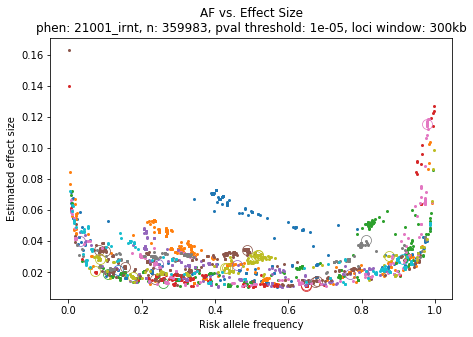

In [107]:
# if maf != 0:
#     ss = ss[(ss.raf>maf)&(ss.raf<1-maf)]
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# fig,ax=plt.subplots(figsize=(6*1.2,4*1.2))
# if 'coding' in ss.columns.values and highlight_coding:
#     if get_top_loci:
#         for loci_i in range(n_top_loci):
#             ax.plot(ss[(~ss.coding)&(ss.loci_rank==loci_i)].raf, ss[~ss.coding&(ss.loci_rank==loci_i)].rbeta,'.',ms=4,c=colors[loci_i%10]) #plot noncoding variants
#             ax.plot(ss[ss.coding&(ss.loci_rank==loci_i)].raf, ss[ss.coding&(ss.loci_rank==loci_i)].rbeta, 'o',ms=10,markerfacecolor='none', markeredgewidth=0.75,c=colors[loci_i%10]) #plot coding variants
#     else:
#         ax.plot(ss[~ss.coding].raf, ss[~ss.coding].rbeta,'.',ms=4,c='#1f77b4') #plot noncoding variants
#         ax.plot(ss[ss.coding].raf, ss[ss.coding].rbeta, 'o',ms=10,markerfacecolor='none', markeredgewidth=0.75) #plot coding variants
#         plt.legend(['non-coding','coding'], loc=1)
# else:
#     ax.plot(ss.raf, ss.rbeta,'.',ms=2,alpha=1)
# plt.xlabel('Risk allele frequency')
# plt.ylabel('Estimated effect size')
# plt.title(f'AF vs. Effect Size\nphen: {phen}, n: {n}, pval threshold: {pval_threshold}'
#           +(f', maf>{maf}' if maf!=0 else '')+(f', ld block: {int(ld_window/1000)}kb' if ld_clumping else '')
#           +(f', loci window: {int(ld_window/1000)}kb' if get_top_loci else ''))

In [59]:
# ss[ss.loci_rank==0]

,AC,alt_af,beta,chr,coding,index,loci_rank,low_confidence_variant,minor_AF,minor_allele,n,pos,pval,raf,rbeta,ref,se,tstat,variant,ytx
45092,97648.0,0.135630,0.021448,16,True,11445915,0.0,False,0.135630,C,359983,53656135,3.078100e-10,0.135630,0.021448,G,0.003407,6.2950,16:53656135:G:C,1600.40
45093,18611.0,0.025849,-0.040737,16,False,11445927,0.0,False,0.025849,C,359983,53657949,3.601300e-08,0.974151,0.040737,G,0.007394,-5.5095,16:53657949:G:C,-738.31
45094,18610.0,0.025848,-0.040735,16,False,11445933,0.0,False,0.025848,C,359983,53658724,3.612900e-08,0.974152,0.040735,T,0.007394,-5.5089,16:53658724:T:C,-738.17
45095,23199.0,0.032222,-0.042395,16,False,11445958,0.0,False,0.032222,GGT,359983,53662895,3.973000e-10,0.967778,0.042395,G,0.006778,-6.2553,16:53662895:G:GGT,-885.44
45096,18627.0,0.025871,-0.040664,16,False,11445964,0.0,False,0.025871,C,359983,53664458,3.831700e-08,0.974129,0.040664,A,0.007395,-5.4986,16:53664458:A:C,-736.49
45097,18537.0,0.025747,-0.041304,16,False,11445968,0.0,False,0.025747,T,359983,53665585,2.786500e-08,0.974253,0.041304,TAATAA,0.007436,-5.5545,16:53665585:TAATAA:T,-737.41
45098,97858.0,0.135920,0.021312,16,False,11445984,0.0,False,0.135920,T,359983,53668653,3.847400e-10,0.135920,0.021312,C,0.003404,6.2603,16:53668653:C:T,1590.80
45099,77976.0,0.108310,0.020958,16,False,11445985,0.0,False,0.108310,T,359983,53669178,2.564400e-08,0.108310,0.020958,A,0.003763,5.5690,16:53669178:A:T,1255.90
45100,18441.0,0.025613,-0.041218,16,False,11446044,0.0,False,0.025613,G,359983,53685016,2.840200e-08,0.974387,0.041218,A,0.007425,-5.5511,16:53685016:A:G,-739.87
45101,18631.0,0.025877,-0.040837,16,False,11446114,0.0,False,0.025877,T,359983,53701364,3.360500e-08,0.974123,0.040837,C,0.007396,-5.5217,16:53701364:C:T,-739.50


In [13]:
tb0 = hl.Table.from_pandas(ss)
tb = tb0.annotate(variant = hl.parse_variant(tb0.variant,reference_genome='GRCh37'))
tb = tb.annotate(locus = tb.variant.locus,
                alleles = tb.variant.alleles)
tb = tb.key_by(tb.locus,tb.alleles)

2019-07-22 12:29:25 Hail: WARN: Name collision: field 'index' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['index']


In [128]:
tb_locus = tb.filter(tb.loci_rank==0)

In [14]:
top_variants

['16:53802494',
 '18:57850927',
 '2:635864',
 '2:417167',
 '1:177889025',
 '2:25150116',
 '18:58064846',
 '11:27679916',
 '3:49959570',
 '6:50816887']

In [15]:
# get h2 of phenotype
h2_tb = hl.import_table('gs://nbaya/h2part/updates/ukbb31063.both_sexes.h2part_results.v2.phesant.tsv.gz',impute=True,force=True)
h2 = h2_tb.filter(h2_tb.phenotype==phen).h2_observed.collect()[0]

2019-07-22 12:30:09 Hail: INFO: Reading table to impute column types
2019-07-22 12:30:11 Hail: INFO: Finished type imputation
  Loading column 'source' as type 'str' (imputed)
  Loading column 'phenotype' as type 'str' (imputed)
  Loading column 'description' as type 'str' (imputed)
  Loading column 'n' as type 'float64' (imputed)
  Loading column 'n_cases' as type 'str' (imputed)
  Loading column 'n_controls' as type 'str' (imputed)
  Loading column 'mean_chi2' as type 'float64' (imputed)
  Loading column 'lambdaGC' as type 'float64' (imputed)
  Loading column 'intercept' as type 'float64' (imputed)
  Loading column 'intercept_se' as type 'float64' (imputed)
  Loading column 'intercept_z' as type 'float64' (imputed)
  Loading column 'intercept_p' as type 'float64' (imputed)
  Loading column 'ratio' as type 'str' (imputed)
  Loading column 'ratio_se' as type 'str' (imputed)
  Loading column 'h2_observed' as type 'float64' (imputed)
  Loading column 'h2_observed_se' as type 'float64' (i

In [23]:
ss = hl.read_table(wd+phen+f'.sumstats.coding.pval{pval_threshold}.ht')

In [37]:
ss.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'AC': float64 
    'alt_af': float64 
    'beta': float64 
    'chr': str 
    'coding': bool 
    'index': int64 
    'loci_rank': float64 
    'low_confidence_variant': bool 
    'minor_AF': float64 
    'minor_allele': str 
    'n': int64 
    'pos': int64 
    'pval': float64 
    'raf': float64 
    'rbeta': float64 
    'ref': str 
    'se': float64 
    'tstat': float64 
    'var_exp': float64 
    'variant': struct {
        locus: locus<GRCh37>, 
        alleles: array<str>
    } 
    'ytx': float64 
    'locus': locus<GRCh37> 
    'alleles': array<str> 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [41]:
# set only top hit to have beta = 1, otherwise = 0
mt_all_loci = mt1.annotate_rows(sim_truebeta = hl.literal(top_variants).contains(hl.str(mt1.locus)),
                                real_rbeta = ss[mt1.locus,mt1.alleles].rbeta,
                                real_raf = ss[mt1.locus,mt1.alleles].raf,
                                loci_rank = ss[mt1.locus,mt1.alleles].loci_rank,
                                real_pval = ss[mt1.locus,mt1.alleles].pval,
                                coding = ss[mt1.locus,mt1.alleles].coding,
                                real_var_exp = ss[mt1.locus,mt1.alleles].var_exp)
mt_all_loci = mt_all_loci.filter_rows(hl.is_defined(ss[mt_all_loci.locus,mt_all_loci.alleles]))

In [42]:
sim_all_loci = calculate_phenotypes(mt=mt_all_loci,genotype=mt_all_loci.dosage,beta=mt_all_loci.sim_truebeta,h2=h2)

In [44]:
cov_list = ['isFemale','age','age_squared','age_isFemale',
                    'age_squared_isFemale']+['PC{:}'.format(i) for i in range(1, 21)]
cov_list = list(map(lambda x: sim_all_loci[x] if type(x) is str else x,cov_list))
cov_list += [1]

gwas_locus = hl.linear_regression_rows(y=sim_all_loci.y,
                                       x=sim_all_loci.dosage,
                                       covariates=cov_list,
                                       pass_through=['sim_truebeta','real_rbeta',
                                                     'raf','loci_rank','real_pval',
                                                     'coding','real_var_exp'])

ValueError: 'linear_regression_rows/pass_through': MatrixTable has no row field 'sim_truebeta, real_rbeta'

In [32]:
ss.count()

3691

In [35]:
mt_all_loci.count_rows()

3691

In [129]:
# mt_locus = mt_all_loci.filter_rows(hl.is_defined(tb_locus[mt_all_loci.locus,mt_all_loci.alleles]))

In [19]:
# print(mt_locus.aggregate_rows(hl.agg.stats(mt_locus.beta)))
print(mt_all_loci.aggregate_rows(hl.agg.stats(mt_all_loci.beta)))

Struct(mean=7.48261993161934e-07, stdev=0.0008650210594349266, min=0.0, max=1.0, n=13364303, sum=10.000000000000014)


In [ ]:
ht_all_loci = mt_all_loci.rows()

In [153]:
mt_locus.checkpoint(wd+phen+f'.mt_locus.maf{maf}.pval{pval_threshold}.mt')

2019-07-19 18:37:58 Hail: INFO: Coerced sorted dataset
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving----------------------------------------

Exception happened during processing of request from ('127.0.0.1', 59656)
Traceback (most recent call last):
  File "/opt/conda

Py4JError: An error occurred while calling o532.executeJSON

In [137]:
sim_locus = calculate_phenotypes(mt=mt_all_loci,genotype=mt_all_loci.dosage,beta=mt_all_loci.beta,h2=h2)

In [152]:
sim_locus = sim_locus.checkpoint(wd+phen+f'.sim_locus.maf{maf}.pval{pval_threshold}.mt')

KeyboardInterrupt: 

In [144]:
cov_list = ['isFemale','age','age_squared','age_isFemale',
                    'age_squared_isFemale']+['PC{:}'.format(i) for i in range(1, 21)]
cov_list = list(map(lambda x: sim_locus[x] if type(x) is str else x,cov_list))
cov_list += [1]

In [146]:
gwas_locus = hl.linear_regression_rows(y=sim_locus.y,
                                       x=sim_locus.dosage,
                                       covariates=cov_list)

KeyboardInterrupt: 

In [ ]:
gwas_locus.describe()

In [ ]:
min_idx = np.argmax(sim_locus.beta.collect())

In [ ]:
ld = hl.row_correlation(mt_locus.dosage).to_numpy()[min_idx]